## ASSIGNMENT-2

TEAM-NAME: NERF™

IDs: 2021101026, 2021111027, 2021101103

NAMEs: Mitansh Kayathwal, Gnana Prakash Punnavajhala, Vineeth Bhat

### Instructions
 * Fill in the team name, id and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.

In [1]:
!pip3 install tabulate

In [2]:
# List the imports here
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import open3d as o3d
from tabulate import tabulate

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### SECTION 1: Non-Linear least squares optimization for Gaussian function

#### 1.1 Levenberg Marquardt

Implement the Levenberg Marquardt algorithm from scratch using numpy to solve for the parameters of a gaussian distribution.

A Gaussian distribution parametrized by $a,m,s$ is given by:

$$ y(x;a,m,s)=a \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right) \tag{1}$$

##### Problem to solve

> Given a set of observations $y_{obs}$ and $x_{obs}$ we want to find the optimum parameters $a,m,s$ which best fit our observations given an initial estimate.

* Experiment with the number of iterations.
* Experiment with the learning rate.
* Experiment with the tolerance.

Display your results using matplotlib by plotting graphs for 
* The cost function value ($\|r\|^2$) vs the number of iterations
* The Ground Truth data values and the predicted data values.

Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

You can refer to [Shubodh's notes](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02) on the same to get a better grasp of the concept before implementing it.

In [3]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

"""
Assumption: Input data in the form (x,y)
"""

def gaussian(x, amp, mean, std_dev):
    return amp * np.exp(-(x - mean)**2 / (2 * std_dev**2))

def residual(data, amp ,mean, std_dev):
    x = data[:, 0]
    y = data[:, 1]
    return gaussian(x,amp,mean,std_dev)-y

def calc_jacobian(x, amp, mean, std_dev):
    J0 = np.exp(-(x - mean)**2 / (2 * std_dev**2))
    J1 = (amp*(x-mean)/(std_dev**2))*np.exp(-(x - mean)**2 / (2 * std_dev**2))
    J2 = (amp*((x-mean)**2)/(std_dev**3))*np.exp(-(x - mean)**2 / (2 * std_dev**2))
    J = np.column_stack((J0,J1,J2))
    return J

def calc_hessian(J):
    return J.T @ J

def run_LM(data, learning_rate=0.01, iterations=100, tolerance=1e-8):
    costs = []
    num_iterations = []
    """
    Initial guess for Amplitue, Mean and Standard Deviation
    """
    lm_params = [1.5, 1, 1]
    x = data[:, 0]
    I = np.eye(3)
    for i in range(iterations):
        J = calc_jacobian(x, lm_params[0],lm_params[1],lm_params[2])
        H = calc_hessian(J)
        lm_lambda = learning_rate * np.max(np.diag(H))
        H = H + lm_lambda*I
        fx = residual(data, lm_params[0],lm_params[1],lm_params[2])
        cost = fx.T @ fx
        costs.append(cost)
        num_iterations.append(i+1)
        B = - J.T @ fx
        delta_residual = np.linalg.solve(H, B)
        lm_params += delta_residual
        if(cost < tolerance):
            break
    return lm_params, costs, num_iterations

"""
Load data to test LM
"""

data_LM = np.load("./data/data_LM.npy")

##############################################################################
# END OF YOUR CODE
##############################################################################

In [13]:
learning_rates = [0.01, 0.05, 0.1]
epochs = [100, 200, 500, 1000]
tolerance = [1e-6, 1e-7, 1e-8]

best_params = None
min_cost = 10000000
params_lm = None

outputs = []

for lr in learning_rates:
    for num_iter in epochs:
        for tol in tolerance:
            params, costs, num_it = run_LM(data_LM, lr, num_iter, tol)

            outputs.append([lr, num_iter, tol, costs[-1], params[0], params[1], params[2]])

            if(min_cost > costs[-1]):
                min_cost = costs[-1]
                best_params = [lr, num_iter, tol]
                params_lm = params
headers = ["Learning Rate", "No Of Iterations", "Tolerance", "Optimal Cost on Convergence", "Amplitude", "Mean", "Std Dev"]
table = tabulate(outputs, headers, tablefmt="pretty")
print(table)

print("Best Hyper Parameters are: ")
print("Learning Rate: " + str(best_params[0]))
print("Iterations: " + str(best_params[1]))
print("Tolerance: " + str(best_params[2]))
print("Optimal Cost: " + str(min_cost))
print("Obtained Ampliude: " + str(params_lm[0]))
print("Obtained Mean: " + str(params_lm[1]))
print("Obtained Std Dev: " + str(params_lm[2]))

+---------------+------------------+-----------+-----------------------------+--------------------+--------------------+--------------------+
| Learning Rate | No Of Iterations | Tolerance | Optimal Cost on Convergence |     Amplitude      |        Mean        |      Std Dev       |
+---------------+------------------+-----------+-----------------------------+--------------------+--------------------+--------------------+
|     0.01      |       100        |   1e-06   |    0.0075202981675418544    |  6.00030622024788  | 15.005418320335382 | 18.999628702629668 |
|     0.01      |       100        |   1e-07   |    0.0075202981675418544    |  6.00030622024788  | 15.005418320335382 | 18.999628702629668 |
|     0.01      |       100        |   1e-08   |    0.0075202981675418544    |  6.00030622024788  | 15.005418320335382 | 18.999628702629668 |
|     0.01      |       200        |   1e-06   |    0.0075202981675418544    |  6.00030622024788  | 15.005418320335382 | 18.999628702629668 |
|     

## Justification for Hyper-parameters:

Hyperparameters were choosen on the basis of the performance on LM Algorithm based on the lowest cost they give on convergence. We observe that the cost and estimated parameters are almost same for all chosen hyperparmeters.

On the best hyper-parameters, using LM Algorithm, the observed parameters are:
Amplitude(a): 6.00030622024788
Mean(m): 15.005418320335382
Standard Deviation(s): 18.999628702629668



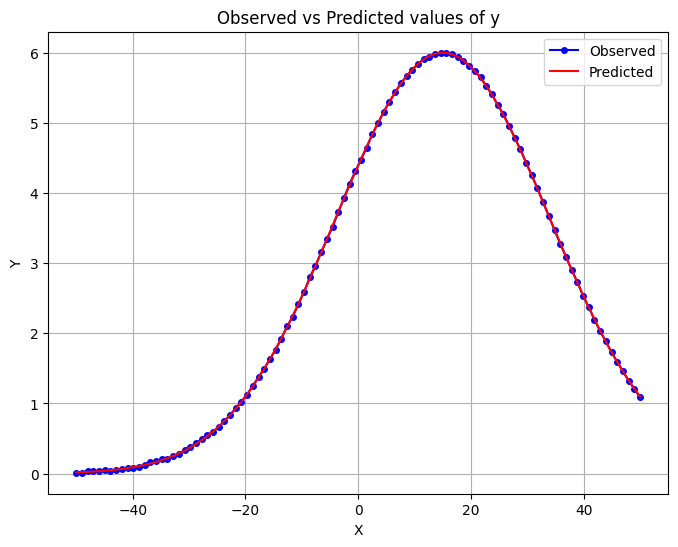

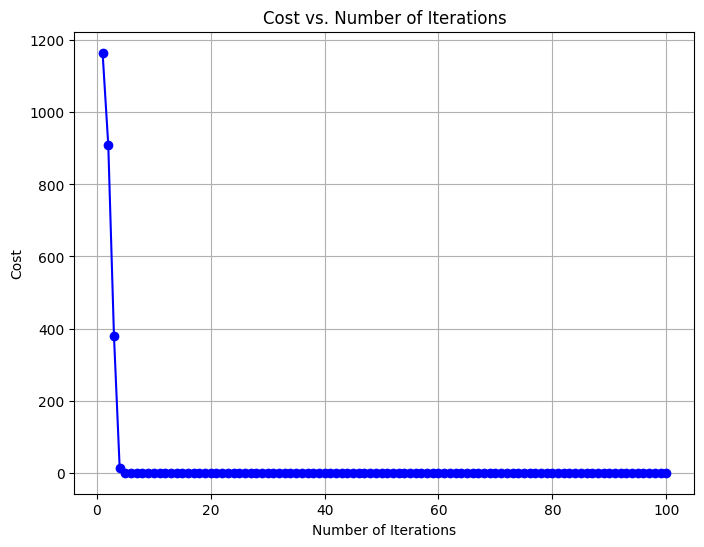

In [5]:
params, costs, num_iterations = run_LM(data_LM, best_params[0], best_params[1], best_params[2])

print("On the best hyper-parameters, using LM Algorithm, the observed parameters are:")
print("Amplitude(a): " + str(params[0]))
print("Mean(m): " + str(params[1]))
print("Standard Deviation(s): " + str(params[2]))
print()

x = data_LM[:, 0]
y_obs = data_LM[:, 1]
y_exp = gaussian(x,params[0],params[1],params[2])

plt.figure(figsize=(8, 6))
plt.plot(x, y_obs, marker='o', linestyle='-', color='blue', markersize=4, label='Observed')
plt.plot(x, y_exp, color='red', label='Predicted')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Observed vs Predicted values of y')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(num_iterations, costs, marker='o', linestyle='-', color='blue', label='Cost')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Number of Iterations')
plt.grid(True)
plt.show()

### SECTION 2: ICP

#### 2.1 Perform Procrustes alignmenton two point clouds with (given) known correspondences. 

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). 

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

**Use *root mean squared error (RSME)* as the alignment error metric.**

Make sure your code is modular as we will use this function in the next sub-part.

In [6]:
def unit_quat(q):
    return list(q / np.linalg.norm(q))

def quat_mul(q1, q2):
    '''
    [q_10, q_11, q_12, q_13] = [q1[0], q1[1], q1[2], q1[3]]
    [q_20, q_21, q_22, q_23] = [q2[0], q2[1], q2[2], q2[3]]
    
    q = [
        q_10*q_20 - q_11*q_21 - q_12*q_22 - q_13*q_23,
        q_10*q_21 + q_11*q_20 + q_12*q_23 - q_13*q_22,
        q_10*q_22 + q_20*q_12 + q_13*q_21 - q_11*q_23,
        q_10*q_23 + q_20*q_13 + q_11*q_22 - q_12*q_21
    ]

    return q
    '''
    quat1 = q1
    quat2 = q2
    
    q0, q1, q2, q3 = quat1
    p0, p1, p2, p3 = quat2
    
    return [
        p0*q0 - p1*q1 - p2*q2 - p3*q3,
        p0*q1 + q0*p1 + p2*q3 - p3*q2,
        p0*q2 + q0*p2 + p3*q1 - p1*q3,
        p0*q3 + q0*p3 + p1*q2 - p2*q1
    ]

def quat_inv(q):
    q = unit_quat(q)

    q_inv = -np.array(q)
    q_inv[0] = -q_inv[0]
    return unit_quat(q_inv)

def rot2quat(rot_matrix):
    '''
    trace = np.trace(rot_matrix)

    q_0 = 0.5 * np.sqrt(1 + trace)
    q_1 = (rot_matrix[2][1] - rot_matrix[1][2]) / (4 * q_0)
    q_2 = (rot_matrix[0][2] - rot_matrix[2][0]) / (4 * q_0)
    q_3 = (rot_matrix[1][0] - rot_matrix[0][1]) / (4 * q_0)

    quaternion = [q_0, q_1, q_2, q_3]

    return quaternion
    '''

    trace = np.trace(rot_matrix)

    q_0 = 0.5 * np.sqrt(1 + trace)
    q_1 = (rot_matrix[2][1] - rot_matrix[1][2]) / (4 * q_0)
    q_2 = (rot_matrix[0][2] - rot_matrix[2][0]) / (4 * q_0)
    q_3 = (rot_matrix[1][0] - rot_matrix[0][1]) / (4 * q_0)

    quaternion = [q_0, q_1, q_2, q_3]

    return quaternion

    
def rot_quat(q_final, q_initial=[1, 0, 0, 0]):
    q_initial_inv = quat_inv(q_initial)
    q_final = unit_quat(q_final)

    quat_prod = quat_mul(q_final, q_initial_inv)
    quat_prod = unit_quat(quat_prod)

    quat_angle = 2 * np.arccos(quat_prod[0])
    return [quat_angle, quat_prod]

def interpolate_quat(angle, q, n_iter=50):
    angle /= 2
    angle *= (1 / n_iter)

    q[0] = 0

    if q[1:] != [0, 0, 0]:
        q = unit_quat(q)

    q = list(np.array(q) * np.sin(angle))
    q[0] = np.cos(angle)

    return unit_quat(q)

def visualize_interpolate(initial_point_cloud, final_point_cloud, final_quat=[1, 0, 0, 0], trans_vector=[0, 0, 0], initial_quat=[1, 0, 0, 0], n_iter=50, init_sleep_time = 0.5):
    [angle, final_rot_quat] = rot_quat(final_quat, initial_quat)

    inter_quat = interpolate_quat(angle, final_rot_quat, n_iter)
    
    inter_quat_rot_matrix = o3d.geometry.get_rotation_matrix_from_quaternion(inter_quat)
    trans_vector = np.array(trans_vector) / n_iter

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(initial_point_cloud)
    vis.add_geometry(final_point_cloud)
    vis.poll_events()
    vis.update_renderer()
    time.sleep(init_sleep_time)

    for _ in range(n_iter):
        points = np.asarray(initial_point_cloud.points)
        rotated_points = inter_quat_rot_matrix[None, ...] @ points[..., None]
        rotated_points = np.reshape(rotated_points, (rotated_points.shape[0], -1))
        initial_point_cloud.points = o3d.utility.Vector3dVector(rotated_points)        
        vis.update_geometry(initial_point_cloud)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.01)
    time.sleep(0.5)

    for _ in range(n_iter):
        points = np.asarray(initial_point_cloud.points)
        points += trans_vector[None, :]
        initial_point_cloud.points = o3d.utility.Vector3dVector(points)
        vis.update_geometry(initial_point_cloud)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.01)
    time.sleep(1)

    vis.destroy_window()

    return initial_point_cloud


def centered_point_cloud_points(point_cloud):
    points = np.asarray(point_cloud.points)
    point_cloud_mean = np.mean(points, axis=0)
    
    centered_points = points - point_cloud_mean
    
    return centered_points, point_cloud_mean

def get_cross_cov_matrix(p_pcd_points, q_pcd_points):
    return q_pcd_points.T @ p_pcd_points

def get_rot_matrix(W):
    U, _, VT = np.linalg.svd(W)
    R = U @ VT
    return R

def ICP_Known(pcd1, pcd2):
    p, p_mean = centered_point_cloud_points(pcd1)
    q, q_mean = centered_point_cloud_points(pcd2)

    W = get_cross_cov_matrix(p, q)

    R = get_rot_matrix(W)
    t = (q_mean[:, None] - R @ p_mean[:, None]).flatten()

    rotated_p = R[None, ...] @ p[..., None]
    rotated_p = np.reshape(rotated_p, (rotated_p.shape[0], -1))

    aligned_p = rotated_p + q_mean

    alignment_error = np.linalg.norm(np.asarray(aligned_p) - np.asarray(pcd2.points))

    return alignment_error, R, t


In [7]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################
pcd1 = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = copy.deepcopy(pcd1)

T = np.eye(4)
R = o3d.geometry.PointCloud.get_rotation_matrix_from_zyx((0, np.pi / 3, np.pi/2))
t = np.array([5, -10, -25]).T
T[:3, :3] = R
T[:3, 3]  = t

pcd2.transform(T)

alignment_error, R_pred, t_pred = ICP_Known(pcd1, pcd2)

pcd3 = visualize_interpolate(pcd1, pcd2, rot2quat(R_pred), t_pred)

print(alignment_error)

# Tried to optimise the get_cross_cov_matrix function
# Works now!! - Error with np.empty because W not initialised to first product when using for loop
# p = np.asarray(pcd1.points)
# q = np.asarray(pcd2.points)
# print(get_cross_cov_matrix(p, q))
# print()
# print(q.T @ p)
# print(np.allclose(q.T @ p, get_cross_cov_matrix(p, q)))

# q1 = np.transpose(q[:, None, :], (0, 2, 1))
# p1 = p[:, None]
# t2 = q1 @ p1
# print()
# print(np.sum(t2, axis=0))

# Tested single line rotation of all points
# test_R = -np.eye(3)
# (-p[..., None] == test_R[None, ...] @ p[..., None]).all()

##############################################################################
# END OF YOUR CODE
##############################################################################

3.7643224850588326e-10


#### 2.2 Implement ICP algorithm with unknown correspondences.

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration.

In [8]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

# Replace "pass" statement with your code
def perform_ICP(pcd_init, pcd_final, n_iters = 10, num_samples = 100, disp_viz = False):
    '''
    We will attempt to align the initial point cloud to final point cloud
    '''
    # copying the pointclouds
    initial_point_cloud = copy.deepcopy(pcd_init)
    final_point_cloud = copy.deepcopy(pcd_final)
    
    # extracting final points
    final_points = np.array(final_point_cloud.points)

    if disp_viz:
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(initial_point_cloud)
        vis.add_geometry(final_point_cloud)
        vis.poll_events()
        vis.update_renderer()

    for i in range(n_iters):
        print("Iteration {} - ".format(i+1), end = "")

        # extracting intial points here as they change on transformation
        initial_points = np.array(initial_point_cloud.points)
        
        # figuring out initial correspondences
        correspondences = []
        
        # selecting random points
        random_indices = np.random.choice(initial_points.shape[0], num_samples, replace=False)
        chosen_points = initial_points[random_indices]

        norms = np.linalg.norm(final_points - chosen_points[:, None], axis=2)

        min_corresps = np.argmin(norms, axis=1)
        selected_final_points = final_points[min_corresps]

        pcd_subset1, pcd_subset2 = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()

        pcd_subset1.points = o3d.utility.Vector3dVector(chosen_points)
        pcd_subset2.points = o3d.utility.Vector3dVector(selected_final_points)
        
        # calculating rotation and translation
        alignment_error, R_pred, t_pred = ICP_Known(pcd_subset1, pcd_subset2)
        print("Alignment error over chosen correspondences: {}".format(alignment_error))

        if disp_viz:
            try:
                viz_num_iters = 50
    
                final_quat=rot2quat(R_pred)
                trans_vector=t_pred
                initial_quat=[1, 0, 0, 0]
    
                [angle, final_rot_quat] = rot_quat(final_quat, initial_quat)
            
                inter_quat = interpolate_quat(angle, final_rot_quat, viz_num_iters)
                
                inter_quat_rot_matrix = o3d.geometry.get_rotation_matrix_from_quaternion(inter_quat)
                trans_vector = np.array(trans_vector) / viz_num_iters
    
                for _ in range(viz_num_iters):
                    points = np.asarray(initial_point_cloud.points)
                    rotated_points = inter_quat_rot_matrix[None, ...] @ points[..., None]
                    rotated_points = np.reshape(rotated_points, (rotated_points.shape[0], -1))
                    initial_point_cloud.points = o3d.utility.Vector3dVector(rotated_points)        
                    vis.update_geometry(initial_point_cloud)
                    vis.poll_events()
                    vis.update_renderer()
                    time.sleep(0.01)
                time.sleep(0.2)
            
                for _ in range(viz_num_iters):
                    points = np.asarray(initial_point_cloud.points)
                    points += trans_vector[None, :]
                    initial_point_cloud.points = o3d.utility.Vector3dVector(points)
                    vis.update_geometry(initial_point_cloud)
                    vis.poll_events()
                    vis.update_renderer()
                    time.sleep(0.01)
                time.sleep(1)
            except:
                vis.destroy_window()
                print("Visualization failed!")
                return;


    if disp_viz:
        vis.destroy_window()

    return initial_point_cloud, final_point_cloud

# see following code


In [9]:
pcd1 = o3d.io.read_point_cloud("./data/toothless.ply")
pcd2 = copy.deepcopy(pcd1)

R = o3d.geometry.PointCloud.get_rotation_matrix_from_zyx((np.pi/3, np.pi/10, np.pi/3))
pcd1.rotate(R)
pcd2.rotate(R)

T = np.eye(4)
# R = o3d.geometry.PointCloud.get_rotation_matrix_from_zyx((np.pi/15, 0, 0))
R = o3d.geometry.PointCloud.get_rotation_matrix_from_zyx((np.pi/10, 0, 0))
t = np.array([5, -40, -25]).T
T[:3, :3] = R
T[:3, 3]  = t

pcd2.transform(T)

PointCloud with 232685 points.

In [10]:
perform_ICP(pcd1, pcd2, num_samples = 250, n_iters = 10, disp_viz = True)

Iteration 1 - Alignment error over chosen correspondences: 317.70230004611017
Iteration 2 - Alignment error over chosen correspondences: 212.87009976474047
Iteration 3 - Alignment error over chosen correspondences: 179.6424554069734
Iteration 4 - Alignment error over chosen correspondences: 140.55363920619766
Iteration 5 - Alignment error over chosen correspondences: 107.03973819141876
Iteration 6 - Alignment error over chosen correspondences: 90.46848368987263
Iteration 7 - Alignment error over chosen correspondences: 71.56334278805649
Iteration 8 - Alignment error over chosen correspondences: 54.89867080764193
Iteration 9 - Alignment error over chosen correspondences: 49.9303423756875
Iteration 10 - Alignment error over chosen correspondences: 40.610865235943336


(PointCloud with 232685 points., PointCloud with 232685 points.)